In [2]:
#import
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
import matplotlib
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
import snowflake.connector
import datetime as dt
import folium
import geopandas as gpd
import calendar
import scipy
import h3
import geojson as gjs

#connect to snowflake
con = snowflake.connector.connect(
user='elliot.safo@deliveroo.co.uk',
account='deliveroo.eu-central-1',
authenticator='externalbrowser',
warehouse='BI_DEVELOPMENT'
)

/Users/elliotsafo/.local/share/virtualenvs/ESPythonProject-PeGlDRVf/lib/python3.7/site-packages/snowflake/connector/options.py:97: UserWarning: You have an incompatible version of 'pyarrow' installed (3.0.0), please install a version that adheres to: 'pyarrow<5.1.0,>=5.0.0; extra == "pandas"'
  _expected_pyarrow_version,
/Users/elliotsafo/.local/share/virtualenvs/ESPythonProject-PeGlDRVf/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


## Testing the hex function by adding hex codes to zone centroids

In [7]:
q_geo = '''SELECT * FROM PRODUCTION.REFERENCE.ZONE_CITY_COUNTRY WHERE BUSINESS_UNIT_NAME = 'Belgium' ORDER BY ZONE_NAME'''
df_geo = pd.read_sql(q_geo,con)
df_geo.head()


,ZONE_ID,ZONE_DRN_ID,ZONE_CODE,ZONE_NAME,CLUSTER_ID,CLUSTER_DRN_ID,CLUSTER_NAME,CITY_ID,CITY_DRN_ID,CITY_NAME,...,PREDOMINANT_PAY_MODEL,PREDOMINANT_PAY_MODEL_PRCT,CNT_RIDERS_3W,IS_PAY_MODEL_HYBRID_ZONE,DELIVERY_ONLY_ZONE,LIVE_CORE_RESTAURANTS,LIVE_MP_RESTAURANTS,MP_ONLY_ZONE,ZONE_POPULATION,GEO_CHANGE_HASH
0,2296,cd08a838-29dd-4c77-9c57-661c133898a5,ALMS,Almere Stad,1853,3175c432-406c-41c2-96e3-03fec713963b,ALMS,599,f6de274a-d9b0-4e27-aa06-32e41cfe7c15,Almere,...,Drop,1.0,30.0,False,False,15.0,14.0,False,104689.0,-7525239250437803838
1,2297,121148b6-d80d-4438-8664-5aa5632d8fd5,ALMO,Almere en omgeving,1852,6e22cd83-983f-4707-8f49-99710b2ad9a0,ALMO,599,f6de274a-d9b0-4e27-aa06-32e41cfe7c15,Almere,...,None,NaN,NaN,None,False,0.0,8.0,True,101025.0,-3768733670575115635
2,1391,be480d13-b9ea-474f-aa3e-93e2bf9732b9,AMF,Amersfoort,924,5c180fe9-0411-489c-b285-1159406901e5,AMF,295,8d81fd36-2f73-4162-85c0-19b5d6b1e549,Amersfoort,...,Drop,1.0,40.0,False,False,27.0,8.0,False,87940.0,2332855441782857538
3,2511,19b569e5-92a9-4373-8aed-776770a575ed,AMVE,Amstelveen,981,d18e1e1e-95c9-4e3d-9c7b-569d107c81d9,ABZ-ACE-AIJ-AMVE-ANWE-AOO-AZO,23,57b9ae45-6987-4502-a64a-c4ad9e5ef9da,Amsterdam,...,Drop,1.0,24.0,False,False,23.0,8.0,False,40246.0,592067626684725820
4,519,71d1225d-9b3e-44cc-a4b7-38df787d0d09,AV1,Amstelveen 1,397,788a660e-1ee1-4fd6-9494-d0b02b181938,AV1,23,57b9ae45-6987-4502-a64a-c4ad9e5ef9da,Amsterdam,...,None,NaN,NaN,None,None,NaN,NaN,False,NaN,-4258169972757134018


In [14]:
#adding hex codes to each ZONE.
#Note: the higher the resolution, the smaller the hex

lst1=[]

for i in range(df_geo.shape[0]):
    hex1=0
    hex1 = h3.geo_to_h3(df_geo['CENTROID_GEO_LAT'][i],df_geo['CENTROID_GEO_LONG'][i], resolution=10)
    lst1.append(hex1)
df_geo['hex_ID'] = lst1


In [16]:
df_geo.head()

,ZONE_ID,ZONE_DRN_ID,ZONE_CODE,ZONE_NAME,CLUSTER_ID,CLUSTER_DRN_ID,CLUSTER_NAME,CITY_ID,CITY_DRN_ID,CITY_NAME,...,PREDOMINANT_PAY_MODEL_PRCT,CNT_RIDERS_3W,IS_PAY_MODEL_HYBRID_ZONE,DELIVERY_ONLY_ZONE,LIVE_CORE_RESTAURANTS,LIVE_MP_RESTAURANTS,MP_ONLY_ZONE,ZONE_POPULATION,GEO_CHANGE_HASH,hex_ID1
0,2296,cd08a838-29dd-4c77-9c57-661c133898a5,ALMS,Almere Stad,1853,3175c432-406c-41c2-96e3-03fec713963b,ALMS,599,f6de274a-d9b0-4e27-aa06-32e41cfe7c15,Almere,...,1.0,30.0,False,False,15.0,14.0,False,104689.0,-7525239250437803838,8a1969c521b7fff
1,2297,121148b6-d80d-4438-8664-5aa5632d8fd5,ALMO,Almere en omgeving,1852,6e22cd83-983f-4707-8f49-99710b2ad9a0,ALMO,599,f6de274a-d9b0-4e27-aa06-32e41cfe7c15,Almere,...,NaN,NaN,None,False,0.0,8.0,True,101025.0,-3768733670575115635,8a1969c7354ffff
2,1391,be480d13-b9ea-474f-aa3e-93e2bf9732b9,AMF,Amersfoort,924,5c180fe9-0411-489c-b285-1159406901e5,AMF,295,8d81fd36-2f73-4162-85c0-19b5d6b1e549,Amersfoort,...,1.0,40.0,False,False,27.0,8.0,False,87940.0,2332855441782857538,8a196900451ffff
3,2511,19b569e5-92a9-4373-8aed-776770a575ed,AMVE,Amstelveen,981,d18e1e1e-95c9-4e3d-9c7b-569d107c81d9,ABZ-ACE-AIJ-AMVE-ANWE-AOO-AZO,23,57b9ae45-6987-4502-a64a-c4ad9e5ef9da,Amsterdam,...,1.0,24.0,False,False,23.0,8.0,False,40246.0,592067626684725820,8a1969500507fff
4,519,71d1225d-9b3e-44cc-a4b7-38df787d0d09,AV1,Amstelveen 1,397,788a660e-1ee1-4fd6-9494-d0b02b181938,AV1,23,57b9ae45-6987-4502-a64a-c4ad9e5ef9da,Amsterdam,...,NaN,NaN,None,None,NaN,NaN,False,NaN,-4258169972757134018,8a1969500037fff


## Adding hex codes to each restaurant

In [25]:
q_rx_geo = '''select restaurant_id, restaurant_name, restaurant_zone_id, restaurant_geo_long, restaurant_geo_lat from production.reference.restaurant_with_company
where restaurant_business_unit_name not in ('Germany','Taiwan','Spain','Israel') order by restaurant_zone_id '''

df_rx_geo = pd.read_sql(q_rx_geo, con)
df_rx_geo.head()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


,RESTAURANT_ID,RESTAURANT_NAME,RESTAURANT_ZONE_ID,RESTAURANT_GEO_LONG,RESTAURANT_GEO_LAT
0,297741,GFC Chicken Shop - South Kensington,1,-0.173698,51.494292
1,179229,MEZCALITO CHELSEA,1,-0.169545,51.488669
2,69685,Little India - Kensington,1,-0.183876,51.498820
3,4028,Maroush - Earl's Court,1,-0.194425,51.493438
4,21090,Harry RT,1,-0.191657,51.500244


In [37]:
#adding hex codes to each RESTAURANT.

lst2=[]

for i in range(df_rx_geo.shape[0]):
    hex2=0
    hex2 = h3.geo_to_h3(df_rx_geo['RESTAURANT_GEO_LAT'][i],df_rx_geo['RESTAURANT_GEO_LONG'][i], resolution=7)
    lst2.append(hex2)
df_rx_geo['hex_ID'] = lst2

In [38]:
df_rx_geo.head()

,RESTAURANT_ID,RESTAURANT_NAME,RESTAURANT_ZONE_ID,RESTAURANT_GEO_LONG,RESTAURANT_GEO_LAT,hex_ID
0,297741,GFC Chicken Shop - South Kensington,1,-0.173698,51.494292,87194ada5ffffff
1,179229,MEZCALITO CHELSEA,1,-0.169545,51.488669,87194ad16ffffff
2,69685,Little India - Kensington,1,-0.183876,51.498820,87194ada5ffffff
3,4028,Maroush - Earl's Court,1,-0.194425,51.493438,87194ada5ffffff
4,21090,Harry RT,1,-0.191657,51.500244,87194ada5ffffff


In [39]:
hex_counts = df_rx_geo.groupby('hex_ID').size().to_frame().reset_index().rename(columns={0:'TOTAL_RESTAURANTS_IN_HEX'})
hex_counts.head()

,hex_ID,TOTAL_RESTAURANTS_IN_HEX
0,871825013ffffff,5
1,87182501effffff,7
2,8718250acffffff,25
3,8718250adffffff,10
4,871825858ffffff,1


In [40]:
df_zone_hex = df_rx_geo[['RESTAURANT_ZONE_ID','hex_ID']].merge(hex_counts, how='left', on='hex_ID')
df_zone_hex.drop_duplicates()
df_zone_hex.head()

,RESTAURANT_ZONE_ID,hex_ID,TOTAL_RESTAURANTS_IN_HEX
0,1,87194ada5ffffff,645
1,1,87194ad16ffffff,556
2,1,87194ada5ffffff,645
3,1,87194ada5ffffff,645
4,1,87194ada5ffffff,645


In [41]:
zone_stats = df_zone_hex.groupby('RESTAURANT_ZONE_ID')['TOTAL_RESTAURANTS_IN_HEX'].agg(['std','mean']).reset_index()
zone_stats

,RESTAURANT_ZONE_ID,std,mean
0,1,75.731659,599.508247
1,2,495.139613,1445.168675
2,3,511.472005,1603.912134
3,4,154.826520,520.404806
4,5,259.019626,1189.362999
...,...,...,...
1940,6647,124.557009,175.678571
1941,6648,103.398098,80.000000
1942,6649,16.498336,20.484848
1943,6650,11.334335,20.796296


/Users/elliotsafo/.local/share/virtualenvs/ESPythonProject-PeGlDRVf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/Users/elliotsafo/.local/share/virtualenvs/ESPythonProject-PeGlDRVf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



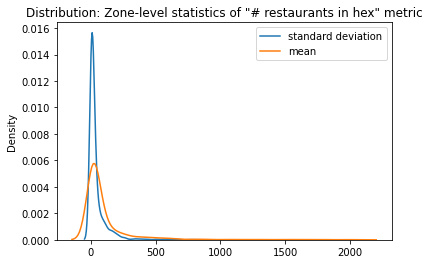

In [42]:
sns.distplot(zone_stats, x=zone_stats['std'], bins=30, hist=False)
sns.distplot(zone_stats, x=zone_stats['mean'], bins=30, hist=False)
plt.title('Distribution: Zone-level statistics of "# restaurants in hex" metric')
plt.legend(['standard deviation','mean'])
# plt.xlim([0,20])
plt.show()

In [43]:
test_df = df_zone_hex
lst3=[]

for i in range(test_df.shape[0]):
    hex3=0
    hex3 = h3.h3_to_geo_boundary(test_df['hex_ID'][i])
    lst3.append(hex3)
test_df['hex_boundary'] = lst3

test_df.head()


,RESTAURANT_ZONE_ID,hex_ID,TOTAL_RESTAURANTS_IN_HEX,hex_boundary
0,1,87194ada5ffffff,645,"((51.50134042921889, -0.1894852185869125), (51..."
1,1,87194ad16ffffff,556,"((51.50284849427419, -0.15716008247707608), (5..."
2,1,87194ada5ffffff,645,"((51.50134042921889, -0.1894852185869125), (51..."
3,1,87194ada5ffffff,645,"((51.50134042921889, -0.1894852185869125), (51..."
4,1,87194ada5ffffff,645,"((51.50134042921889, -0.1894852185869125), (51..."


In [44]:
from shapely.geometry import Polygon

def add_geometry(row):
  points = h3.h3_to_geo_boundary(row['hex_ID'], True)
  return Polygon(points)
#Apply function into our dataframe
test_df['geometry'] = (test_df.apply(add_geometry,axis=1))

In [18]:
import geojson as gjs

def hexagons_dataframe_to_geojson(df_hex, hex_id_field,geometry_field, value_field,file_output = None):

    list_features = []

    for i, row in df_hex.iterrows():
        feature = gjs.Feature(geometry = row[geometry_field],
                          id = row[hex_id_field],
                          properties = {"value": row[value_field]})
        list_features.append(feature)

    feat_collection = gjs.FeatureCollection(list_features)

    if file_output is not None:
        with open(file_output, "w") as f:
            json.dump(feat_collection, f)

    else :
        return feat_collection

In [46]:
geojson_obj = (hexagons_dataframe_to_geojson
                (test_df,
                 hex_id_field='hex_ID',
                 value_field='TOTAL_RESTAURANTS_IN_HEX',
                 geometry_field='geometry'))

In [ ]:
import plotly.express as px

fig = (px.choropleth_mapbox(
                    test_df, 
                    geojson=geojson_obj, 
                    locations='hex_ID', 
                    color='TOTAL_RESTAURANTS_IN_HEX',
                    color_continuous_scale="Viridis",
                    range_color=(0,test_df['TOTAL_RESTAURANTS_IN_HEX'].mean()           ),                  mapbox_style='carto-positron',
                    zoom=7,
#                     center = {"lat": 65.469211, "lon": -136.713865},
                    opacity=0.7,
                    labels={'TOTAL_RESTAURANTS_IN_HEX':'# of restaurants '}))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Total number of orders per hex

In [4]:
q_orders = '''SELECT
id
,CASE WHEN IS_B10_ORDER THEN 1 ELSE 0 END AS B10_ORDER
,CASE WHEN IS_B10_OMDNR THEN 1 ELSE 0 END AS B10_OMDNR
,CASE WHEN IS_B10_UNACCEPTABLE_LATE_15_PLUS THEN 1 ELSE 0 END AS B10_LATE_15_PLUS
,rider_experience_time as RET
,lateness
,total_value
,customer_geo_long
,customer_geo_lat
,restaurant_geo_long
,restaurant_geo_lat
FROM production.denormalised.orders
WHERE business_unit_name not in ('Netherlands','Belgium','')
AND YEAR(order_date) = 2021 and month(order_date) in (9,10,11)'''

df_orders = pd.read_sql(q_orders,con)
df_orders.head()

,ID,B10_ORDER,B10_OMDNR,B10_LATE_15_PLUS,RET,LATENESS,TOTAL_VALUE,CUSTOMER_GEO_LONG,CUSTOMER_GEO_LAT,RESTAURANT_GEO_LONG,RESTAURANT_GEO_LAT
0,742282094,0,0,0,12.416666,0.28,38.24,1.461099,43.573323,1.433380,43.591377
1,743187187,0,0,0,NaN,60.05,20.44,-6.248819,53.367552,-6.250657,53.351477
2,742537932,0,0,0,10.233333,-3.30,9.63,-0.018064,51.571047,-0.013659,51.575133
3,742961332,1,0,1,17.783334,38.50,125.64,-0.190260,50.828806,-0.155185,50.825339
4,743016008,0,0,0,11.033333,-10.67,131.79,-0.164127,51.455021,-0.184705,51.463346


In [5]:
#adding hex codes to each RESTAURANT.

lst4=[]
lst5=[]

for i in range(df_orders.shape[0]):
    hex4=0
    hex5=0
    hex4 = h3.geo_to_h3(df_orders['RESTAURANT_GEO_LAT'][i],df_orders['RESTAURANT_GEO_LONG'][i], resolution=9)
    hex5 = h3.geo_to_h3(df_orders['CUSTOMER_GEO_LAT'][i],df_orders['CUSTOMER_GEO_LONG'][i], resolution=9)
    lst4.append(hex4)
    lst5.append(hex5)
df_orders['rx_hex_ID'] = lst4
df_orders['cx_hex_ID'] = lst5


In [29]:
hex_rx_orders = df_orders.groupby('rx_hex_ID')['ID'].count().to_frame().reset_index().rename(columns={'ID':'rx_order_volume'})
hex_rx_orders.head()

hex_cx_orders = df_orders.groupby('cx_hex_ID')['ID'].count().to_frame().reset_index().rename(columns={'ID':'cx_order_volume'})
hex_cx_orders.head()

,cx_hex_ID,cx_order_volume
0,89196824827ffff,2
1,8919682482bffff,2
2,8919682482fffff,2
3,89196824877ffff,1
4,89196824887ffff,1


In [6]:
hex_cx_order_attributes = pd.pivot_table(
   df_orders,
   index=['cx_hex_ID'],
   aggfunc={'B10_ORDER': np.mean, 'RET': np.mean, 'TOTAL_VALUE': np.mean, 'ID': len}
).rename(columns={'B10_ORDER':'b10_order_rate','ID': 'cx_order_count','RET':'cx_ret','TOTAL_VALUE':'avg_cx_order_value'}).reset_index()

In [7]:
from shapely.geometry import Polygon

# def add_geometry(row):
#   points = h3.h3_to_geo_boundary(row['rx_hex_ID'], True)
#   return Polygon(points)
# #Apply function into our dataframe
# hex_rx_orders['geometry'] = (hex_rx_orders.apply(add_geometry,axis=1))

def add_geometry(row):
  points = h3.h3_to_geo_boundary(row['cx_hex_ID'], True)
  return Polygon(points)
hex_cx_order_attributes['geometry'] = (hex_cx_order_attributes.apply(add_geometry,axis=1))


In [8]:
# geojson_rx_obj = (hexagons_dataframe_to_geojson
#                 (hex_rx_orders,
#                  hex_id_field='rx_hex_ID',
#                  value_field='rx_order_volume',
#                  geometry_field='geometry'))

geojson_cx_obj = (hexagons_dataframe_to_geojson
                (hex_cx_order_attributes,
                 hex_id_field='cx_hex_ID',
                 value_field='cx_order_count',
                 geometry_field='geometry'))


NameError: name 'hexagons_dataframe_to_geojson' is not defined

In [ ]:
#Rx Orders

import plotly.express as px

fig = (px.choropleth_mapbox(
                    hex_rx_orders, 
                    geojson=geojson_rx_obj, 
                    locations='rx_hex_ID', 
                    color='rx_order_volume',
                    color_continuous_scale="Viridis",
                    range_color=(0,(hex_rx_orders['rx_order_volume'].mean()) * 1.5         ),                  mapbox_style='carto-positron',
                    zoom=7,
#                     center = {"lat": 65.469211, "lon": -136.713865},
                    opacity=0.7,
                    labels={'hex_rx_orders':'# of restaurant orders '}))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
# Cx Orders
import plotly.express as px
fig = (px.choropleth_mapbox(
                    hex_cx_order_attributes, 
                    geojson=geojson_cx_obj, 
                    locations='cx_hex_ID', 
                    color='avg_cx_order_value',
                    color_continuous_scale="Viridis",
                    range_color=(10,(hex_cx_order_attributes['avg_cx_order_value'].mean()) *1.75         ),                  mapbox_style='carto-positron',
                    zoom=7,
#                     center = {"lat": 65.469211, "lon": -136.713865},
                    opacity=0.4,
                    labels={'hex_cx_order_attributes':'avg customer order value '}))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Order Volume per Customer

In [129]:
q_orders_per_customer = '''SELECT
id
,user_id
,customer_geo_long
,customer_geo_lat
,restaurant_geo_long
,restaurant_geo_lat
FROM production.denormalised.orders
WHERE city_name = 'Sydney'
AND YEAR(order_date) = 2021'''

df_orders_per_customer = pd.read_sql(q_orders_per_customer,con)

In [130]:
#adding hex codes to each RESTAURANT.

lst6=[]

for i in range(df_orders_per_customer.shape[0]):
    hex6=0
    hex6 = h3.geo_to_h3(df_orders_per_customer['CUSTOMER_GEO_LAT'][i],df_orders_per_customer['CUSTOMER_GEO_LONG'][i], resolution=10)
    lst6.append(hex6)
df_orders_per_customer['cx_hex_ID'] = lst6

In [131]:
hex_orders_per_customer = df_orders_per_customer.groupby('cx_hex_ID')[['ID','USER_ID']].nunique().reset_index().rename(columns={'ID':'cx_order_volume','USER_ID':'cx_volume'})
hex_orders_per_customer.head()

,cx_hex_ID,cx_order_volume,cx_volume
0,8a754e64992ffff,1792,65
1,8abe081a4d8ffff,1,1
2,8abe081a4d97fff,2,1
3,8abe081a4db7fff,2,1
4,8abe081a6437fff,2,2


In [132]:
hex_orders_per_customer['ov_per_customer'] = hex_orders_per_customer['cx_order_volume']/hex_orders_per_customer['cx_volume']
hex_orders_per_customer.head()

,cx_hex_ID,cx_order_volume,cx_volume,ov_per_customer
0,8a754e64992ffff,1792,65,27.569231
1,8abe081a4d8ffff,1,1,1.000000
2,8abe081a4d97fff,2,1,2.000000
3,8abe081a4db7fff,2,1,2.000000
4,8abe081a6437fff,2,2,1.000000


In [133]:
def add_geometry(row):
  points = h3.h3_to_geo_boundary(row['cx_hex_ID'], True)
  return Polygon(points)

hex_orders_per_customer['geometry'] = (hex_orders_per_customer.apply(add_geometry,axis=1))

In [134]:
geojson_cx_ov_obj = (hexagons_dataframe_to_geojson
                (hex_orders_per_customer,
                 hex_id_field='cx_hex_ID',
                 value_field='ov_per_customer',
                 geometry_field='geometry'))


In [ ]:
fig = (px.choropleth_mapbox(
                    hex_orders_per_customer, 
                    geojson=geojson_cx_ov_obj, 
                    locations='cx_hex_ID', 
                    color='ov_per_customer',
                    color_continuous_scale="Viridis",
                    range_color=(0,20    ),                  mapbox_style='carto-positron',
                    zoom=7,
#                     center = {"lat": 65.469211, "lon": -136.713865},
                    opacity=0.7,
                    labels={'hex_cx_orders':'# of customer orders '}))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


# Average number of visible restaurants per customer hex


In [57]:
q_selection = '''SELECT
SESSION_ID
,LAT
,LON
,ASAP_RESTAURANTS_CNT
,AVAILABLE_RESTAURANTS_CNT
FROM PRODUCTION.SESSIONS.CONSUMER_SESSIONS
WHERE ASAP_RESTAURANTS_CNT IS NOT NULL AND AVAILABLE_RESTAURANTS_CNT IS NOT NULL
AND DATE_KEY BETWEEN '2021-11-01' AND '2021-11-30'
AND LAT IS NOT NULL AND LON IS NOT NULL
AND NOT BOT
AND BUSINESS_UNIT_NAME = 'London'
AND HOUR(SESSION_START_AT_LOCAL) in (6,7,8,9)
'''

df_selection = pd.read_sql(q_selection,con)
df_selection.head()

,SESSION_ID,LAT,LON,ASAP_RESTAURANTS_CNT,AVAILABLE_RESTAURANTS_CNT
0,5d39793e36fbdc8ce25b439b2b3be8c0,51.512971,-0.183715,54,363
1,5d01c0f6ca645b452b9a796a9735b451,51.459316,0.081101,55,101
2,5de8a173208672f73f81826411799095,51.517082,-0.062640,170,711
3,5dc8b6ec7c2692952fae02b714f5e5e5,51.498516,0.090946,10,42
4,5d04541faf10c559f8e7ab5fc63f5e09,51.430090,-0.175311,33,260


In [58]:
lst7=[]

for i in range(df_selection.shape[0]):
    hex7=0
    hex7 = h3.geo_to_h3(df_selection['LAT'][i],df_selection['LON'][i], resolution=10)
    lst7.append(hex7)
df_selection['cx_hex_ID'] = lst7

In [59]:
selection_per_hex = df_selection.groupby('cx_hex_ID')[['ASAP_RESTAURANTS_CNT','AVAILABLE_RESTAURANTS_CNT']].mean().reset_index()
selection_per_hex.head()

,cx_hex_ID,ASAP_RESTAURANTS_CNT,AVAILABLE_RESTAURANTS_CNT
0,8a182d5b5807fff,74.0,184.0
1,8a182d786077fff,48.0,121.0
2,8a182d923a2ffff,39.0,153.0
3,8a1841a2b957fff,126.0,363.0
4,8a1841a2d747fff,136.0,406.0


In [60]:
def add_geometry(row):
  points = h3.h3_to_geo_boundary(row['cx_hex_ID'], True)
  return Polygon(points)

selection_per_hex['geometry'] = (selection_per_hex.apply(add_geometry,axis=1))

geojson_cx_selection_obj = (hexagons_dataframe_to_geojson
                (selection_per_hex,
                 hex_id_field='cx_hex_ID',
                 value_field='ASAP_RESTAURANTS_CNT',
                 geometry_field='geometry'))

In [ ]:
fig = (px.choropleth_mapbox(
                    selection_per_hex, 
                    geojson=geojson_cx_selection_obj, 
                    locations='cx_hex_ID', 
                    color='ASAP_RESTAURANTS_CNT',
                    color_continuous_scale="Viridis",
                    range_color=(0, (selection_per_hex['ASAP_RESTAURANTS_CNT'].max())*0.1   ),                  mapbox_style='carto-positron',
                    zoom=7,
#                     center = {"lat": 65.469211, "lon": -136.713865},
                    opacity=0.7,
                    labels={'selection_per_hex':'avg # of asap rx '}))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# CLV

In [11]:
q_clv = '''with latest as
(select
user_id
,max(created_at) as max_created_at
from production.denormalised.denormalised_user_address_with_postcode
group by 1
)

,user_details as (
SELECT
a.user_id
,a.created_at
,a.customer_zone_id
,a.geo_long
,a.geo_lat
FROM production.denormalised.denormalised_user_address_with_postcode a
INNER JOIN latest b
ON a.user_id=b.user_id AND a.created_at=b.max_created_at)

,latest_clv AS (
SELECT
  *
FROM production.miscellaneous.growth_user_level_data_tbl
WHERE DATE_KEY = (select max(date_key) - 1 FROM production.miscellaneous.growth_user_level_data_tbl))

SELECT
a.*
,b.CBM_EXP_OPPO * b.CBM_W52_DISCOUNTED_ORDERS as user_clv
FROM user_details a
LEFT JOIN latest_clv b
ON a.user_id=b.user_id
//where user_clv is not NULL
;
'''

df_clv = pd.read_sql(q_clv,con)
df_clv.head(10)

,USER_ID,CREATED_AT,CUSTOMER_ZONE_ID,GEO_LONG,GEO_LAT,USER_CLV
0,40273162,2020-12-14 19:31:36.606802,2213.0,-3.097653,51.013439,3.965214
1,17671041,2022-01-30 20:27:16.053725,165.0,3.045396,50.623612,NaN
2,11288868,2020-07-27 08:36:29.284111,1110.0,153.359082,-28.101485,NaN
3,43219409,2021-02-12 18:21:35.251779,1100.0,-0.637551,51.512620,0.753949
4,11378307,2018-05-10 20:05:38.752921,NaN,-0.490210,38.350260,NaN
5,30311668,2020-11-12 18:26:45.420711,1085.0,12.426565,41.799927,5.534509
6,32324634,2022-01-30 12:30:35.608336,788.0,114.192394,22.289246,-0.075448
7,13322919,2020-12-27 11:16:11.563721,343.0,103.968982,1.361392,NaN
8,48660690,2021-05-17 15:46:01.160048,1331.0,0.050900,51.548046,1.967445
9,8695596,1970-01-01 00:00:00.000000,NaN,0.000000,0.000000,NaN


In [13]:
df_clv.dropna()

,USER_ID,CREATED_AT,CUSTOMER_ZONE_ID,GEO_LONG,GEO_LAT,USER_CLV
0,40273162,2020-12-14 19:31:36.606802,2213.0,-3.097653,51.013439,3.965214
3,43219409,2021-02-12 18:21:35.251779,1100.0,-0.637551,51.512620,0.753949
5,30311668,2020-11-12 18:26:45.420711,1085.0,12.426565,41.799927,5.534509
6,32324634,2022-01-30 12:30:35.608336,788.0,114.192394,22.289246,-0.075448
8,48660690,2021-05-17 15:46:01.160048,1331.0,0.050900,51.548046,1.967445
...,...,...,...,...,...,...
51300574,26563448,2020-05-05 04:58:17.575038,1735.0,114.123721,22.495229,-0.161451
51300575,44274627,2021-03-06 18:09:19.418497,623.0,-1.979391,50.751408,-6.719388
51300576,43858078,2021-06-21 19:12:08.782247,4502.0,-3.175270,55.952922,2.139964
51300577,5917133,2022-01-21 21:11:41.894533,165.0,3.065164,50.640395,4.160002


In [15]:
lst8=[]

for i in range(df_clv.shape[0]):
    hex8=0
    hex8 = h3.geo_to_h3(df_clv['GEO_LAT'][i],df_clv['GEO_LONG'][i], resolution=9)
    lst8.append(hex8)
df_clv['cx_hex_ID'] = lst8

In [16]:
clv_per_hex = df_clv.groupby('cx_hex_ID')['USER_CLV'].mean().reset_index()
clv_per_hex.head()

,cx_hex_ID,USER_CLV
0,891496ae547ffff,NaN
1,891801940c3ffff,149.813879
2,8918019445bffff,19.505091
3,89180194483ffff,0.744527
4,89180194487ffff,18.019769


In [19]:
def add_geometry(row):
  points = h3.h3_to_geo_boundary(row['cx_hex_ID'], True)
  return Polygon(points)

clv_per_hex['geometry'] = (clv_per_hex.apply(add_geometry,axis=1))

geojson_cx_selection_obj = (hexagons_dataframe_to_geojson
                (clv_per_hex,
                 hex_id_field='cx_hex_ID',
                 value_field='USER_CLV',
                 geometry_field='geometry'))

In [ ]:
import plotly.express as px

fig = (px.choropleth_mapbox(
                    clv_per_hex, 
                    geojson=geojson_cx_selection_obj, 
                    locations='cx_hex_ID', 
                    color='USER_CLV',
                    color_continuous_scale="Viridis",
                    range_color=(0, (clv_per_hex['USER_CLV'].mean())*2   ),                  mapbox_style='carto-positron',
                    zoom=7,
#                     center = {"lat": 65.469211, "lon": -136.713865},
                    opacity=0.7,
                    labels={'clv_per_hex':'avg clv '}))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()